In [1]:
#autoreload
%load_ext autoreload
%autoreload 2

import torch
from torchmetrics import AUROC
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import os

import sys
sys.path.append("../../src_clasificacion_vistas/common")

import pycimg

In [ ]:
current_file_dir = os.getcwd()
train_results_json="../out_evaluate_patch_224_reanot2/train_scores.json"
val_results_json="../out_evaluate_patch_224_reanot2/val_scores.json"
train_results_json=os.path.join(current_file_dir,train_results_json)    
val_results_json=os.path.join(current_file_dir,val_results_json)    


def create_tables(train_data,clases):
    labels=[]
    preds=[]
    filenames=[]
    imags=[]
    for d in train_data:
        truth=[]
        pred=[]
        gt=d['ground_truth']
        scores=d['scores']
        d['filename']
        for defecto in clases:
            truth.append(gt[defecto])
            pred.append(scores[defecto])
        labels.append(truth)
        preds.append(pred)
        filenames.append(d['filename'])
            
    labels=torch.tensor(labels)
    preds=torch.tensor(preds)

    return preds,labels,filenames


with open(train_results_json, "r") as f:
    train_dict = json.load(f)

with open(val_results_json, "r") as f:
    val_dict = json.load(f)    

train_data=train_dict['train_results']
val_data = val_dict['val_results']
clases=list(train_dict['train_results'][0]['ground_truth'].keys())

print(len(train_data))
print(len(val_data))

1050
277


In [3]:
preds_train,labels_train,filenames_train=create_tables(train_data,clases)
preds_val,labels_val,filenames_val=create_tables(val_data,clases)
print(len(filenames_train))

1050


# Cantidad de Vistas de con cada defecto

In [4]:
print("==========================================")
print("  ** VAL **")
print("==========================================")

n_por_defecto=labels_val.sum(dim=0)
for k in range(len(clases)):
    print(f'{clases[k]} : {int(n_por_defecto[k].item())}')

k=labels_val.sum(dim=1)

nbuenos=torch.sum(k==0)
print("N sin defectos:",nbuenos.item())
print("N total:",labels_val.shape[0])

print("\n==========================================")
print("  ** TRAIN **")
print("==========================================")

n_por_defecto=labels_train.sum(dim=0)
for k in range(len(clases)):
    print(f'{clases[k]} : {int(n_por_defecto[k].item())}')

k=labels_train.sum(dim=1)

nbuenos=torch.sum(k==0)
print("N sin defectos:",nbuenos.item())
print("N total:",labels_train.shape[0])

  ** VAL **
green : 20
hollow : 11
light_scars : 30
oil_spots : 17
plu_stickers : 10
rotten : 17
scars : 19
skin_breakdown : 18
surface : 82
N sin defectos: 104
N total: 277

  ** TRAIN **
green : 104
hollow : 33
light_scars : 119
oil_spots : 75
plu_stickers : 32
rotten : 109
scars : 100
skin_breakdown : 97
surface : 287
N sin defectos: 331
N total: 1050


# Análisis AUROC por categorías por vistas

In [5]:
f_auroc=AUROC(task='multilabel',num_labels=len(clases),average='none')
res=f_auroc(preds_val,labels_val.int())
res=res.tolist()

aucs={}
for c,auc in zip(clases,res):
    aucs[c]=auc
    print(f'AUC-val({c}) : {auc:.3f}')


AUC-val(green) : 0.996
AUC-val(hollow) : 0.992
AUC-val(light_scars) : 0.972
AUC-val(oil_spots) : 0.982
AUC-val(plu_stickers) : 1.000
AUC-val(rotten) : 0.955
AUC-val(scars) : 0.977
AUC-val(skin_breakdown) : 0.946
AUC-val(surface) : 0.966


In [7]:
# Juntarlo todo
# preds_train,labels_train,filenames_train,imags_train
# preds_val,labels_val,filenames_val,imags_val

preds_all=np.concatenate((preds_train,preds_val),axis=0)
labels_all=np.concatenate((labels_train,labels_val),axis=0)
filenames_all=filenames_train+filenames_val
filenames_all[:3]

['data/mandarins/clementine/KDC/20220808_154231_Img_20220808_154156produccionClementina/20250218_1153_002399.npz',
 'data/mandarins/clementine/KDC/20220808_154231_Img_20220808_154156produccionClementina/20250218_1153_000569.npz',
 'data/mandarins/clementine/KDC/20220808_154231_Img_20220808_154156produccionClementina/20250218_1154_000577.npz']

In [15]:
import cv2
from matplotlib.backends.backend_pdf import PdfPages

bce=torch.nn.BCELoss(reduction='none')
print(preds_all.shape,labels_all.shape)

pred_tensor=torch.tensor(preds_all)
label_tensor=torch.tensor(labels_all)
print(pred_tensor.shape,label_tensor.shape)

loss=bce(torch.tensor(preds_all[:,:]),torch.tensor(labels_all[:,:]).float())
print(loss.shape)
loss=loss.mean(axis=1).numpy()

idx_sort=np.argsort(loss)[::-1]



nombres_cortos=[c[:6] for c in clases]

numpaginas=150
umbral_defectuosidad = 0.1
defectuosidad=loss


selected_files=[]
selected_preds=[]
selected_labels=[]
selected_imags=[]

selected_basenames=[]
selected_defectuosidad=[]



for i in range(len(idx_sort)):
    
        idx=idx_sort[i]
        if i > numpaginas or defectuosidad[idx] < umbral_defectuosidad:
            break     
        filename=filenames_all[idx]
        pred=preds_all[idx]
        lab=labels_all[idx]
        
        selected_files.append(filename)
        selected_preds.append(pred)
        selected_labels.append(lab)
        
        basename=os.path.basename(filename)
        selected_basenames.append(basename)
        selected_defectuosidad.append(defectuosidad[idx])
        
print("Defectuosidad minima= ",min(selected_defectuosidad))
print("Numpages=",len(selected_files))        
        
with PdfPages('bce_fruit_sort_defect.pdf') as pdf :
    for idx in range(len(selected_defectuosidad)): # Estos están ordenados por defectuosidad
        
        filename=selected_files[idx]
        pred=selected_preds[idx]
        lab=selected_labels[idx]
        fig, axes=plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 2]})
        pos = axes[0].get_position()
        axes[0].set_position([pos.x0, pos.y0, pos.width, pos.height * 0.6])
        axes[0].bar(nombres_cortos,lab)
        axes[0].bar(nombres_cortos,pred)

        
        axes[0].tick_params(axis='x',rotation=90)
        axes[0].set_ylim([0,1])

        imagen_name=filename.replace("npz","png")
        imagen_name=os.path.join("..",imagen_name)
        imagen=cv2.imread(imagen_name)
        imagen=cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
        width=imagen.shape[1]
        imagen=imagen[:,:width//10,:]
        print(imagen.shape)
        axes[1].imshow(imagen)
        #axes[1].imshow(selected_imags[idx])
        axes[1].axis('off')
        axes[1].set_title(f'{selected_basenames[idx]} - {selected_defectuosidad[idx]:.3f}')
        
        
        pdf.savefig(fig)
        plt.close(fig)
   
        
idx_sort2=np.argsort(selected_basenames)
        

with PdfPages('bce_fruit_alph.pdf') as pdf :
    for i in range(len(idx_sort2)):
        idx=idx_sort2[i]
        filename=selected_files[idx]
        pred=selected_preds[idx]
        lab=selected_labels[idx]
        fig, axes=plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 2]})
        pos = axes[0].get_position()
        axes[0].set_position([pos.x0, pos.y0, pos.width, pos.height * 0.6])
        axes[0].bar(nombres_cortos,lab)
        axes[0].bar(nombres_cortos,pred)

        
        axes[0].tick_params(axis='x',rotation=90)
        axes[0].set_ylim([0,1])
        imagen_name=filename.replace("npz","png")
        imagen_name=os.path.join("..",imagen_name)
        imagen=cv2.imread(imagen_name)
        imagen=cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
        width=imagen.shape[1]
        imagen=imagen[:,:width//10,:]
        axes[1].imshow(imagen)

        #axes[1].imshow(selected_imags[idx])
        axes[1].axis('off')
        axes[1].set_title(f'{selected_basenames[idx]} - {selected_defectuosidad[idx]:.3f}')
        
        
        pdf.savefig(fig)
        plt.close(fig)


(1327, 9) (1327, 9)
torch.Size([1327, 9]) torch.Size([1327, 9])
torch.Size([1327, 9])
Defectuosidad minima=  0.36539194
Numpages= 151
(2035, 190, 3)
(3025, 270, 3)
(2233, 202, 3)
(2057, 190, 3)
(1145, 220, 3)
(1768, 228, 3)
(2167, 210, 3)
(668, 176, 3)
(1115, 218, 3)
(2739, 252, 3)
(3091, 282, 3)
(2233, 212, 3)
(2783, 246, 3)
(1969, 180, 3)
(2981, 274, 3)
(2101, 192, 3)
(2365, 212, 3)
(555, 186, 3)
(2255, 204, 3)
(2387, 216, 3)
(2321, 204, 3)
(2343, 212, 3)
(2255, 202, 3)
(2475, 216, 3)
(2717, 260, 3)
(1384, 178, 3)
(1012, 254, 3)
(2079, 192, 3)
(2079, 180, 3)
(2255, 186, 3)
(2233, 206, 3)
(2343, 222, 3)
(2145, 168, 3)
(1784, 230, 3)
(2145, 188, 3)
(1930, 192, 3)
(2043, 224, 3)
(1384, 180, 3)
(2321, 210, 3)
(2101, 194, 3)
(3267, 272, 3)
(2321, 210, 3)
(804, 200, 3)
(1969, 206, 3)
(2123, 200, 3)
(2607, 234, 3)
(955, 188, 3)
(2761, 240, 3)
(1837, 164, 3)
(3223, 266, 3)
(2167, 200, 3)
(2145, 198, 3)
(2057, 188, 3)
(2255, 212, 3)
(1115, 230, 3)
(2299, 208, 3)
(2321, 210, 3)
(3091, 274, 3)


In [21]:
print(len(selected_basenames))

print(selected_files[:5])
lista_selected_jsons=list(set(selected_files))
lista_selected_jsons.sort()
print(len(lista_selected_jsons))
print(lista_selected_jsons[:5])

lista_pngs=[f.replace(".npz",".png") for f in lista_selected_jsons]

print(lista_pngs[:5])


151
['data/mandarins/nardocot/manfredi/20250220_1244_000149.npz', 'data/oranges/navel/manfredi/20250224_1413_000281.npz', 'data/mandarins/nardocot/manfredi/20250220_1200_000049.npz', 'data/mandarins/nardocot/manfredi/20250220_1321_002228.npz', 'data/mandarins/nardocot/manfredi/20250220_1325_002277.npz']
151
['data/mandarins/clementine/KDC/20220803_230703_CLEMENTINE_Encoder_rot/20250217_1641_000002.npz', 'data/mandarins/clementine/KDC/20220803_230703_CLEMENTINE_Encoder_rot/20250217_1641_000008.npz', 'data/mandarins/clementine/KDC/20220803_230825_CLEMENTINE_Encoder_Geens/20250217_1651_002014.npz', 'data/mandarins/clementine/KDC/20220803_230825_CLEMENTINE_Encoder_Geens/20250217_1651_002016.npz', 'data/mandarins/clementine/KDC/20220803_230921_CLEMENTINE_Encoder_OilSpots/20250217_1706_000028.npz']
['data/mandarins/clementine/KDC/20220803_230703_CLEMENTINE_Encoder_rot/20250217_1641_000002.png', 'data/mandarins/clementine/KDC/20220803_230703_CLEMENTINE_Encoder_rot/20250217_1641_000008.png', '

[0.32931084 0.37355088 0.40855338 0.44022139 0.48834316]


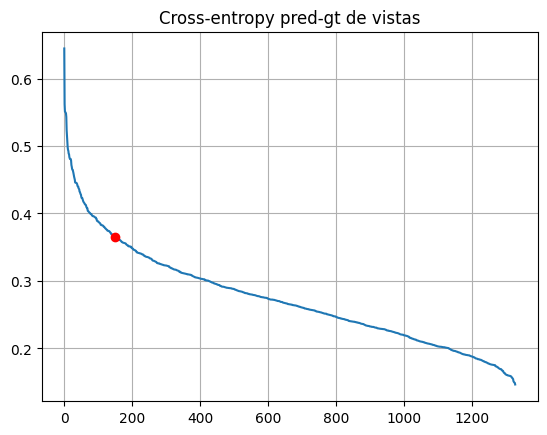

In [19]:
sorted_defectuosidad=np.sort(defectuosidad)[::-1]


_=plt.plot(sorted_defectuosidad)
#_=plt.xlim([0,2000])
_=plt.grid()
_=plt.title("Cross-entropy pred-gt de vistas")
_=plt.plot(150,sorted_defectuosidad[150],'ro')

print(np.percentile(sorted_defectuosidad,[80, 90,95,97,99]))

In [22]:
# Copiar los pngs a un directorio
import shutil

target_dir='/home/aalbiol/Desktop/reanot2_results/imags_f'

for png in lista_pngs:
    pngrel=os.path.join("../",png)
    jsonrel=pngrel.replace(".png",".json")
    shutil.copy(pngrel,target_dir)
    shutil.copy(jsonrel,target_dir)